# Import libraries

In [1]:
# forgot what was it but cude gave an error in kaggle notebook without it 
!sed -i 's/from scipy.spatial import ConvexHull, QhullError/from scipy.spatial import ConvexHull/g' /opt/conda/lib/python3.10/site-packages/skimage/morphology/convex_hull.py

In [2]:
!pip install albumentations==0.4.6
!pip install pycocotools
!pip install yolov5

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.2/117.2 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for albumentations: filename=albumentations-0.4.6-py3-none-any.whl size=65173 sha256=09fe639c5c48844050652c491fa21db151e8f3885d081774d6bbbd93f29a4233
  Stored in directory: /root/.cache/pip/wheels/f9/d7/0c/6ed42fd872f7d1af78b25045f8b16be330f2c70ae72c83e37d
Successfully built albumentations
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.3.1
    Uninstalling albumentations-1.3.1:
      Successfully uninstalled albumentations-1.3.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 426.2/426.2 kB 8.7 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.4/953.4 kB 17.3 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 699.7/699.7 kB 47.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.5/819.5 kB 47.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
import numpy as np 
import pandas as pd 
import torchvision
from torchvision import transforms, datasets, models
import torch
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import albumentations
from albumentations.pytorch.transforms import ToTensor
from albumentations.pytorch.transforms import ToTensorV2
import cv2
import os
import glob
import xml.etree.ElementTree as ET
import shutil
from sklearn import preprocessing
import yaml
import pycocotools
import json
from torch.utils.data import DataLoader, Dataset

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
'''# some aditional packs for frcnn metrics
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_utils.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_eval.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/transforms.py")
from engine import train_one_epoch, evaluate'''

'# some aditional packs for frcnn metrics\nos.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py")\nos.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py")\nos.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_utils.py")\nos.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_eval.py")\nos.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/transforms.py")\nfrom engine import train_one_epoch, evaluate'

# YOLO data preparing

In [5]:
annotations_path = "/kaggle/input/face-mask-detection/annotations/"
images_path = "/kaggle/input/face-mask-detection/images/"

In [6]:
dataset = {
            "file":[],
            "name":[],    
            "width":[],
            "height":[],
            "xmin":[],
            "ymin":[],   
            "xmax":[],
            "ymax":[],
           }

for anno in glob.glob(annotations_path+"/*.xml"):
    tree = ET.parse(anno)
    
    for elem in tree.iter():
        if 'size' in elem.tag:
            for attr in list(elem):
                if 'width' in attr.tag: 
                    width = int(round(float(attr.text)))
                if 'height' in attr.tag:
                    height = int(round(float(attr.text)))    

        if 'object' in elem.tag:
            for attr in list(elem):
                
                if 'name' in attr.tag:
                    name = attr.text                 
                    dataset['name']+=[name]
                    dataset['width']+=[width]
                    dataset['height']+=[height] 
                    dataset['file']+=[anno.split('/')[-1][0:-4]+'.png'] 
                            
                if 'bndbox' in attr.tag:
                    for dim in list(attr):
                        if 'xmin' in dim.tag:
                            xmin = int(round(float(dim.text)))
                            dataset['xmin']+=[xmin]
                        if 'ymin' in dim.tag:
                            ymin = int(round(float(dim.text)))
                            dataset['ymin']+=[ymin]                                
                        if 'xmax' in dim.tag:
                            xmax = int(round(float(dim.text)))
                            dataset['xmax']+=[xmax]                                
                        if 'ymax' in dim.tag:
                            ymax = int(round(float(dim.text)))
                            dataset['ymax']+=[ymax]

In [7]:
df=pd.DataFrame(dataset)
df.head()
# https://www.kaggle.com/code/qwerty29544/face-mask-detection

file                   name  width  height  xmin  ymin  \
0  maksssksksss737.png              with_mask    400     226    28    55   
1  maksssksksss737.png              with_mask    400     226    98    62   
2  maksssksksss737.png  mask_weared_incorrect    400     226   159    50   
3  maksssksksss737.png              with_mask    400     226   293    59   
4  maksssksksss737.png              with_mask    400     226   352    51   

   xmax  ymax  
0    46    71  
1   111    78  
2   193    90  
3   313    80  
4   372    72

In [8]:
le = preprocessing.LabelEncoder()
df['class'] = le.fit_transform(df['name'])

mapping = dict(zip(le.classes_, range(len(le.classes_))))
keys_list = list(mapping.keys())

# move column to fit converting loop
column_to_move = df.pop("class")

# insert column with insert(location, column_name, column_value)

df.insert(4, "class", column_to_move)
df.head()

file                   name  width  height  class  xmin  \
0  maksssksksss737.png              with_mask    400     226      1    28   
1  maksssksksss737.png              with_mask    400     226      1    98   
2  maksssksksss737.png  mask_weared_incorrect    400     226      0   159   
3  maksssksksss737.png              with_mask    400     226      1   293   
4  maksssksksss737.png              with_mask    400     226      1   352   

   ymin  xmax  ymax  
0    55    46    71  
1    62   111    78  
2    50   193    90  
3    59   313    80  
4    51   372    72

In [9]:
def validate_and_clip_bbox(bbox):
    """
    Validate and clip the bounding box values to be within [0.0, 1.0].

    Parameters:
    bbox (tuple): Bounding box tuple (x_min, y_min, x_max, y_max).

    Returns:
    tuple: Corrected bounding box.
    """
    x_min, y_min, x_max, y_max = bbox
    clipped_bbox = (max(0, min(x_min, 1)), max(0, min(y_min, 1)), 
                    max(0, min(x_max, 1)), max(0, min(y_max, 1)))

    if clipped_bbox != bbox:
        print(f"Warning: Bounding box {bbox} is out of range. Clipped to {clipped_bbox}.")

    return clipped_bb

In [10]:

def convert_to_yolov5(df, unique_img_names):

    df_array = np.array(df)

    # for each object
    for i in range(len(df)):
        print_buffer = []

        point =  df_array[i]
        img_name = point[0]

        # for each unique object
        for unique_img_name in unique_img_names:
           if img_name == unique_img_name:

              class_id = point[4]

              # converting bbox
              X = (point[5] + point[7]) / 2.0
              Y = (point[6] + point[8]) / 2.0
              Width    = (point[7] - point[5])
              Height   = (point[8] - point[6])

              # cordinate normalization
              image_c, image_w, image_h = point[1], float(point[2]), float(point[3])
              X /= image_w
              Y /= image_h
              Width    /= image_w
              Height   /= image_h
            
              # add to bbbox file
              print_buffer.append("{} {:.3f} {:.3f} {:.3f} {:.3f}".format(class_id, X, Y, Width, Height))

        # give name to file
        save_file_name = os.path.join(txt_annotations_directory, img_name.replace("png", "txt"))

        # save
        print("\n".join(print_buffer), file= open(save_file_name, "w"))

In [11]:
txt_annotations_directory = '/kaggle/working/converted_annotations/'
os.makedirs(txt_annotations_directory, exist_ok=True)

# get unique file names
unique_img_names = df['file'].unique()
print(len(unique_img_names))

convert_to_yolov5(df, unique_img_names)

853


In [12]:
def normalize_images_in_folder(folder_path):
    # Iterate through all files in the folder
    for filename in os.listdir(folder_path):
        if filename.endswith((".jpg", ".jpeg", ".png")):
            image_path = os.path.join(folder_path, filename)
            image = cv2.imread(image_path)  # Load the image

            if image is not None:
                normalized_image = image / 255.0  # Normalize pixel values to [0, 1]
                yield normalized_image

In [13]:
normalize_images_in_folder(images_path)

<generator object normalize_images_in_folder at 0x7a98990eab20>

In [14]:
# add all annotations and images in one map for rcnn
for name in df['file'].unique():
    shutil.copy("/kaggle/input/face-mask-detection/images/"+name, txt_annotations_directory)

normalize_images_in_folder('/kaggle/working/converted_annotations')

<generator object normalize_images_in_folder at 0x7a98990eb140>

In [15]:
image_ids = df['file'].unique()
train_ids = image_ids[:int(0.9*len(image_ids))]
val_ids = image_ids[int(0.93*len(image_ids)):]
test_ids = image_ids[int(0.97*len(image_ids)):]


print(f'# изображений {len(image_ids)}')
print(f'# train изображений {len(train_ids)}')
print(f'# val изображений {len(val_ids)}')
print(f'# test изображений {len(test_ids)}')

# изображений 853
# train изображений 767
# val изображений 60
# test изображений 26


In [16]:
train_df = df[df['file'].isin(train_ids)]
val_df = df[df['file'].isin(val_ids)]
test_df = df[df['file'].isin(test_ids)]
rcnn_source_folder = train_df+val_df

# create train, val, test, rcnn folders
output_folders = ["train", "val", 'test']
for folder in output_folders:
    if not os.path.exists(folder):
        os.makedirs(folder)

# Creating subfolders inside the main folders
subfolders = ["images", "labels"]
for upper_folder in output_folders:
    for subfolder in subfolders:
        subfolder_path = os.path.join(upper_folder, subfolder)
        if not os.path.exists(subfolder_path):
            os.makedirs(subfolder_path)

In [17]:
# split images to train, test folders

def image_folderator(df, path, source):
  for index, row in df.iterrows():
    filename = str(row['file'])
    source_path = os.path.join(source, filename)
    destination_path = os.path.join(path, filename)

    shutil.copy(source_path, destination_path)

# annotations to labels folder
def label_folderator(df, path, source):
  for index, row in df.iterrows():
    filename = str(row['file'])
    filename_without_extension = os.path.splitext(filename)[0]
    new_filename = filename_without_extension + ".txt"

    source_path = os.path.join(source, new_filename)
    destination_path = os.path.join(path, new_filename)

    shutil.copy(source_path, destination_path)

In [18]:

train_images_path = '/kaggle/working/train/images'
val_images_path = '/kaggle/working/val/images'
test_images_path = '/kaggle/working/test/images'

train_labels_path = '/kaggle/working/train/labels'
val_labels_path = '/kaggle/working/val/labels'
test_labels_path = '/kaggle/working/test/labels'

image_folderator(train_df, train_images_path, images_path)
image_folderator(val_df, val_images_path, images_path)
image_folderator(test_df, test_images_path, images_path)

label_folderator(train_df, train_labels_path, txt_annotations_directory)
label_folderator(val_df, val_labels_path, txt_annotations_directory)
label_folderator(test_df, test_labels_path, txt_annotations_directory)

In [19]:
def plot_bounding_box(image, annotation_list):
    annotations = np.array(annotation_list)
    w, h = image.size

    plotted_image = ImageDraw.Draw(image)

    transformed_annotations = np.copy(annotations)
    print(transformed_annotations)
    transformed_annotations[:,[1,3]] = annotations[:,[1,3]] * w
    transformed_annotations[:,[2,4]] = annotations[:,[2,4]] * h

    transformed_annotations[:,1] = transformed_annotations[:,1] - (transformed_annotations[:,3] / 2)
    transformed_annotations[:,2] = transformed_annotations[:,2] - (transformed_annotations[:,4] / 2)
    transformed_annotations[:,3] = transformed_annotations[:,1] + transformed_annotations[:,3]
    transformed_annotations[:,4] = transformed_annotations[:,2] + transformed_annotations[:,4]

    for ann in transformed_annotations:
        obj_cls, x0, y0, x1, y1 = ann
        plotted_image.rectangle(((x0,y0), (x1,y1)))

        plotted_image.text((x0, y0 - 10), class_id_to_name_mapping[(int(obj_cls))], fill="#000")


    plt.imshow(np.array(image))
    plt.show()

[[1.    0.841 0.212 0.022 0.053]]


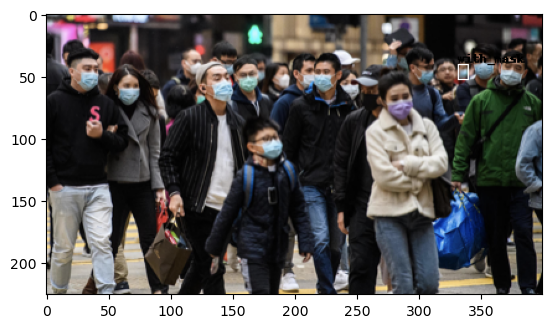

In [20]:
class_id_to_name_mapping = dict(zip(mapping.values(), mapping.keys()))
# choose random annotations
annotation_random= !ls /kaggle/working/converted_annotations/*txt | shuf -n 1
annotation_random

from PIL import Image, ImageDraw

annotation_file = annotation_random[0]
with open(annotation_file, "r") as file:
    annotation_list = file.read().split("\n")[:-1]
    annotation_list = [x.split(" ") for x in annotation_list]
    annotation_list = [[float(y) for y in x ] for x in annotation_list]

#Get the corresponding image file
image_file = annotation_file.replace("txt", "png")
assert os.path.exists(image_file)

#Load the image
image = Image.open(image_file)

#Plot the Bounding Box
plot_bounding_box(image, annotation_list)

In [21]:
data = {
    'train': '/kaggle/working/train/',
    'val': '/kaggle/working/val',
    'nc': len(df['class'].unique()),
    'names': keys_list}



with open('data.yaml', 'w') as yaml_file:
    yaml.dump(data, yaml_file)

In [22]:
my_hyps = {
    'lr0': 0.01,
    'lrf': 0.01,
    'momentum': 0.937,
    'weight_decay': 0.0005,
    'warmup_epochs': 3.0,
    'warmup_momentum': 0.8,
    'warmup_bias_lr': 0.1,
    'box': 0.05,
    'cls': 0.5,
    'cls_pw': 1.0,
    'obj': 1.0,
    'obj_pw': 1.0,
    'iou_t': 0.2,
    'anchor_t': 4.0,
    'fl_gamma': 0.0,
    'hsv_h': 0.056559,
    'hsv_s': 0.33711,
    'hsv_v': 0.14023,
    'degrees': 9.2719,
    'translate': 0.87277,
    'scale': 0.83478,
    'shear': 6.0846,
    'perspective': 0.00018913,
    'flipud': 0.14391,
    'fliplr': 0.075522,
    'mosaic': 0.75871,
    'mixup': 0.55525,
    'copy_paste': 0.34837,
    'anchors': 3.0}

with open('my_hyps.yaml', 'w') as yaml_file:
    yaml.dump(my_hyps, yaml_file)

In [23]:
RES_DIR = '/kaggle/working/result_dir'

In [24]:
!git clone https://github.com/ultralytics/yolov5  # clone
!cd yolov5
!pip install -r /kaggle/working/yolov5/requirements.txt  # install## finetune p5 models

Cloning into 'yolov5'...
remote: Enumerating objects: 16314, done.
remote: Counting objects: 100% (211/211), done.
remote: Compressing objects: 100% (174/174), done.
remote: Total 16314 (delta 97), reused 100 (delta 37), pack-reused 16103
Receiving objects: 100% (16314/16314), 15.10 MiB | 31.11 MiB/s, done.
Resolving deltas: 100% (11128/11128), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 44.2 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: Pillow
    Found existing installation: Pillow 9.5.0
    Uninstalling Pillow-9.5.0:
      Successfully uninstalled Pillow-9.5.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydata-profiling 4.3.1 requires scipy<1.11,>=1.4.1, but you have scipy 1.11.1 which is incompatible.


# YOLO hypsearch
it takes forever

In [ ]:
#!python /kaggle/working/yolov5/train.py --batch -1 --epochs 10 --data /kaggle/working/data.yaml --weights yolov5m.pt --cache --evolve

# Yolo training

In [ ]:
!python /kaggle/working/yolov5/train.py --batch -1 --weights yolov5m.pt  --epochs 500 --data /kaggle/working/data.yaml --cache --img 640 --name {RES_DIR} --hyp /kaggle/working/my_hyps.yaml

 449 epochs completed in 2.758 hours.
* mAP50   
  *                    all 0.801
  *  mask_weared_incorrect 0.995
  *              with_mask 0.607 
  *           without_mask 0.8


In [ ]:
# how it must be
image = Image.open('/kaggle/working/result_dir/val_batch0_labels.jpg')
image

In [ ]:
# how it is for real
#Load the image
image = Image.open('/kaggle/working/result_dir/val_batch0_pred.jpg')
image

In [ ]:
sdfsdf

# F_Rcnn data prepare

In [26]:
''' add to function from example splitter to gate same data split like yolo data, 
and train_data flag because eval and trin need img_ids in different format'''

class FaceMaskDataset(torch.utils.data.Dataset):

    def __init__(self, images_dir, annotation_dir,width, height, transforms=None, exclude_ids=[], train_data=True):
        self.transforms = transforms
        self.images_dir = images_dir
        self.annotation_dir = annotation_dir
        self.height = height
        self.width = width
        self.train_data = train_data
        
        # сортировка изображений
        all_imgs = [image for image in sorted(os.listdir(images_dir))]
        self.imgs = [img for img in all_imgs if img not in exclude_ids]
        all_annots = [image for image in sorted(os.listdir(annotation_dir))]
        self.annotate = [annot for annot in all_annots if annot.replace('.xml', '.png') in self.imgs]
        
        # на 0й позиции находится фон
        self.classes = [_, 'without_mask','with_mask','mask_weared_incorrect']

    def __getitem__(self, idx):

        img_name = self.imgs[idx]
        image_path = os.path.join(self.images_dir, img_name)

        # изменение цвета и размера изображения    
        img = cv2.imread(image_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        img_res = cv2.resize(img_rgb, (self.width, self.height), cv2.INTER_AREA)
        # нормализация изображения
        img_res /= 255.0
        
        # аннотация
        annot_filename = self.annotate[idx]
        annot_file_path = os.path.join(self.annotation_dir, annot_filename)
        
        boxes = []
        labels = []
        tree = et.parse(annot_file_path)
        root = tree.getroot()
        
        # высота и ширина изобрадения
        wt = img.shape[1]
        ht = img.shape[0]
        
        # ограничивающие рамки
        for member in root.findall('object'):
            labels.append(self.classes.index(member.find('name').text))
            
            # bounding box
            xmin = int(member.find('bndbox').find('xmin').text)
            xmax = int(member.find('bndbox').find('xmax').text)
            
            ymin = int(member.find('bndbox').find('ymin').text)
            ymax = int(member.find('bndbox').find('ymax').text)
            
            
            xmin_corr = (xmin/wt)*self.width
            xmax_corr = (xmax/wt)*self.width
            ymin_corr = (ymin/ht)*self.height
            ymax_corr = (ymax/ht)*self.height
            
            boxes.append([xmin_corr, ymin_corr, xmax_corr, ymax_corr])
        
        # перевод boxes в формат torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)
        
        labels = torch.as_tensor(labels, dtype=torch.int64)


        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["area"] = area
        target["iscrowd"] = iscrowd
        
        if self.train_data == False:
            image_id = idx
        else:
            image_id = torch.tensor([idx])
        target["image_id"] = image_id


        if self.transforms:
            
            sample = self.transforms(image = img_res,
                                     bboxes = target['boxes'],
                                     labels = labels)
            
            img_res = sample['image']
            target['boxes'] = torch.Tensor(sample['bboxes'])
            
            
            
        return img_res, target

    def __len__(self):
        return len(self.imgs)

In [27]:
import xml.etree.ElementTree as et

# проверка датасета
dataset = FaceMaskDataset(images_path, annotations_path, 224, 224)
print('length of dataset = ', len(dataset), '\n')

img, target = dataset[78]
print('Image shape = ', img.shape, '\n','Target - ', target)


length of dataset =  853 

Image shape =  (224, 224, 3) 
 Target -  {'boxes': tensor([[113.1163, 146.7200, 163.7209, 205.5200]]), 'labels': tensor([2]), 'area': tensor([2975.5537]), 'iscrowd': tensor([0]), 'image_id': tensor([78])}


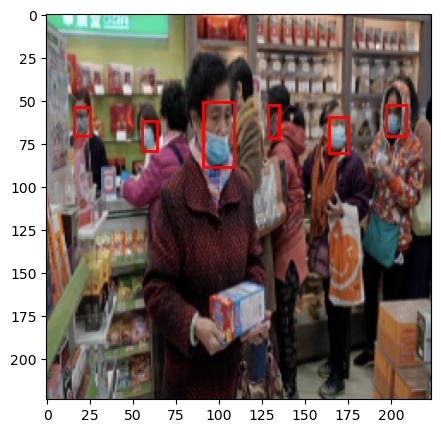

In [28]:
# Вспомогательная функция для визуализации bbox

def plot_img_bbox(img, target):
    fig, a = plt.subplots(1,1)
    fig.set_size_inches(5,5)
    a.imshow(img)
    for box in (target['boxes']):
        x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = patches.Rectangle((x, y),
                                 width, height,
                                 linewidth = 2,
                                 edgecolor = 'r',
                                 facecolor = 'none')

        # Отрисуем bbox поверх картинки
        a.add_patch(rect)
    plt.show()
    
img, target = dataset[35]
plot_img_bbox(img, target)

In [29]:
def get_transform(train):
    
    if train:
        return A.Compose([
                            #A.HorizontalFlip(0.5),
                            #A.RandomBrightnessContrast(p=0.2),
                            #A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=30, p=0.5),
                            ToTensorV2(p=1.0) 
                        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
    else:
        return A.Compose([
                            ToTensorV2(p=1.0)
                        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

In [30]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [31]:
import albumentations as A

dataset = FaceMaskDataset(images_path, annotations_path, 480, 480,
                          transforms=get_transform(train=True),
                          exclude_ids=np.concatenate((val_ids, test_ids)))

dataset_val = FaceMaskDataset(images_path, annotations_path, 480, 480,
                              transforms=get_transform(train=False),
                              exclude_ids=np.concatenate((train_ids, test_ids)),
                              train_data=False)

dataset_test = FaceMaskDataset(images_path, annotations_path, 480, 480,
                               transforms=get_transform(train=False),
                               exclude_ids=np.concatenate((train_ids, val_ids)),
                               train_data=False)



data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=10, shuffle=True, num_workers=4,
    collate_fn=collate_fn)

data_loader_val = torch.utils.data.DataLoader(
    dataset_val, batch_size=10, shuffle=True, num_workers=4,
    collate_fn=collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=10, shuffle=False, num_workers=4,
    collate_fn=collate_fn)

In [32]:
def get_model_instance_segmentation(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
   
    in_features = model.roi_heads.box_predictor.cls_score.in_features

    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In [ ]:
'''import optuna

def objective(trial):
    # Define hyperparameters to be optimized
    lr = trial.suggest_float("lr", 1e-5, 1e-3, log=True)
    momentum = trial.suggest_float("momentum", 0.8, 0.99)
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-4, log=True)
    
    num_epochs = 10
    num_classes = 4
    
    model = get_model_instance_segmentation(num_classes)
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    model.to(device)

    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

    len_dataloader = len(data_loader)
    best_loss = float('inf')  # Initialize with a very high value
    
    for epoch in range(num_epochs):
        model.train()  
        epoch_loss = 0
        for imgs, annotations in data_loader:
            
            imgs = list(img.to(device) for img in imgs)
            annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
            loss_dict = model(imgs, annotations)
            losses = sum(loss for loss in loss_dict.values())        

            optimizer.zero_grad()
            losses.backward()
            optimizer.step()         
            epoch_loss += losses.item()
    # Calculate average loss over all epochs
    average_loss = epoch_loss / num_epochs

    return average_loss  # Return the average loss
    
# Create a study object and specify the optimization direction
study = optuna.create_study(direction="minimize")

# Start the hyperparameter optimization
study.optimize(objective, n_trials=10)

# Print the result
print(study.best_trial)'''

* 'lr': 0.000841522687826933
* 'momentum': 0.937694392068468
* 'weight_decay': 7.295183586686054e-05
With these params result worse than with standart :)

# F_Rcnn teaching

In [33]:
'''standart training loop with added best epoch saver and val_data evaluation to get mAP'''

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

num_classes = 4

model = get_model_instance_segmentation(num_classes)

num_epochs = 10

model.to(device)


params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                                momentum=0.9, weight_decay=0.00005)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)
len_dataloader = len(data_loader)
best_loss = float('inf')  # Initialize with a very high value


for epoch in range(num_epochs):
    model.train()
    i = 0    
    epoch_loss = 0
    for imgs, annotations in data_loader:
        i += 1
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        loss_dict = model(imgs, annotations)
        losses = sum(loss for loss in loss_dict.values())        

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()         
        epoch_loss += losses.item()
        
        if epoch_loss < best_loss:
            best_loss = epoch_loss
            torch.save(model.state_dict(), 'best_rcnn_model.pth')# Save the model
    model.eval()
    print('Epoch=', epoch, 'Epoch_loss= ',epoch_loss)
    # Evaluate the model
    evaluate(model, data_loader_val, device=device)  # Ensure you have an evaluate function defined

    # Update the scheduler
    lr_scheduler.step()
print('Finished')

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 90.7MB/s] 


KeyboardInterrupt: 

optimizer = torch.optim.SGD(params, lr=0.005,
                                momentum=0.9, weight_decay=0.0005)

* Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.490
* Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.748
* Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.577


In [34]:
# вспомогательная функция принимает исходный прогноз и порог iou

def apply_nms(orig_prediction, iou_thresh=0.3):
    
    keep = torchvision.ops.nms(orig_prediction['boxes'], orig_prediction['scores'], iou_thresh)
    
    final_prediction = orig_prediction
    final_prediction['boxes'] = final_prediction['boxes'][keep]
    final_prediction['scores'] = final_prediction['scores'][keep]
    final_prediction['labels'] = final_prediction['labels'][keep]
    
    return final_prediction

def torch_to_pil(img):
    return transforms.ToPILImage()(img).convert('RGB')

# Test data visualization and model results compare

In [35]:

def plot_many_images(img_tensors, annotations_list, predict=True, annotations=True):
    # Number of images
    num_images = len(img_tensors)

    # Create a subplot for each image
    fig, axes = plt.subplots(1, num_images)
    fig.set_size_inches(5 * num_images, 5)  # Adjust the figure size

    # Iterate over all images and annotations
    for ax, img_tensor, annotation in zip(axes, img_tensors, annotations_list):
        # Detach and move image tensor to CPU, then convert to numpy
        if annotations == True:
            annotation = apply_nms(annotation, iou_thresh=0.5)
        img = img_tensor.detach().cpu().permute(1, 2, 0).numpy()
        ax.imshow(img)

        mask_dic = {1: 'without_mask', 2: 'with_mask', 3: 'mask_weared_incorrect'}

        for i, box in enumerate(annotation["boxes"]):
            # Ensure box coordinates are detached and converted to Python types
            xmin, ymin, xmax, ymax = box.detach().cpu().numpy()

            # Create and add the rectangle patch
            rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=1, edgecolor='r', facecolor='none')
            ax.add_patch(rect)

            # Process label and score
            label = mask_dic[int(annotation['labels'][i].item())]  # Use .item() to get Python number
            if predict:
                score = int(annotation['scores'][i].item() * 100)  # Use .item() to get Python number
                ax.text(xmin, ymin, f"{label} : {score}%", horizontalalignment='center', verticalalignment='center', fontsize=20, color='b')
            else:
                ax.text(xmin, ymin, label, horizontalalignment='center', verticalalignment='center', fontsize=20, color='b')

        ax.axis('off')  # Optionally turn off the axis for a cleaner look

    plt.show()


In [36]:
# Load the pretrained model
frcnn = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
in_features = frcnn.roi_heads.box_predictor.cls_score.in_features

frcnn.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes=4)

# Load your custom weights
model_weights = torch.load('/kaggle/input/weights/best_rcnn_model.pth', map_location=torch.device('cpu'))

# Update model with your weights
frcnn.load_state_dict(model_weights)

<All keys matched successfully>

In [37]:
'''For visualize test images, need to separate annotaions from images, than get predictions for images'''
# split
for imgs, annotations in data_loader_test:
        imgs = list(img for img in imgs)#img.to(device)
        annotations = [{k: v for k, v in t.items()} for t in annotations]#v.to(device)
        break



In [38]:
# get predictions
frcnn.eval()
preds = frcnn(imgs)

## Images like must be

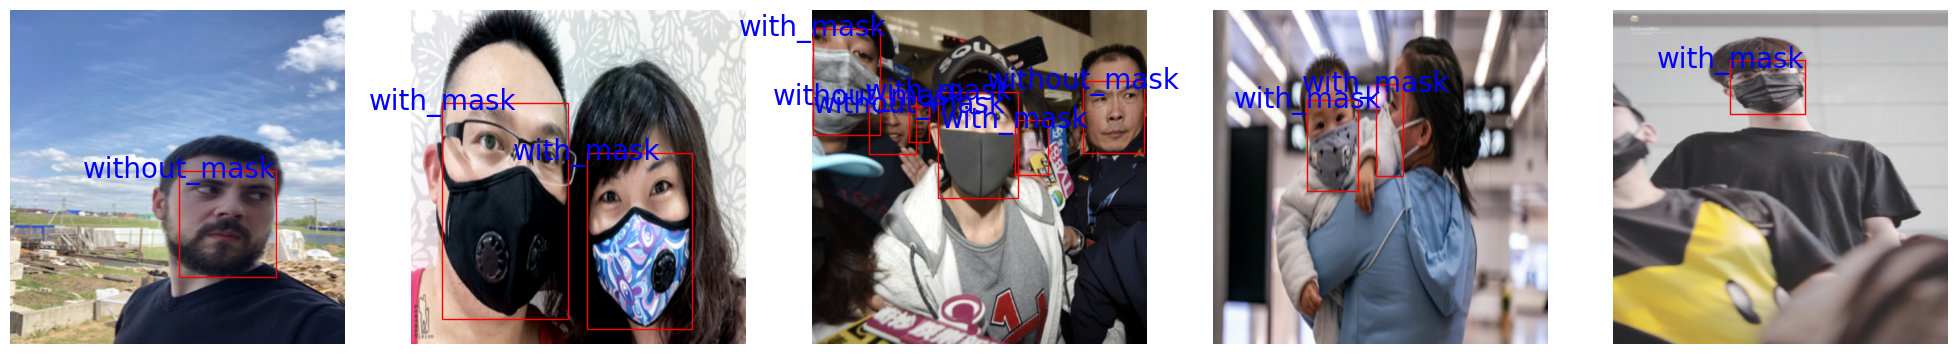

In [39]:
plot_many_images(imgs[:5],annotations[:5],False,False)

### F-RCNN Reality

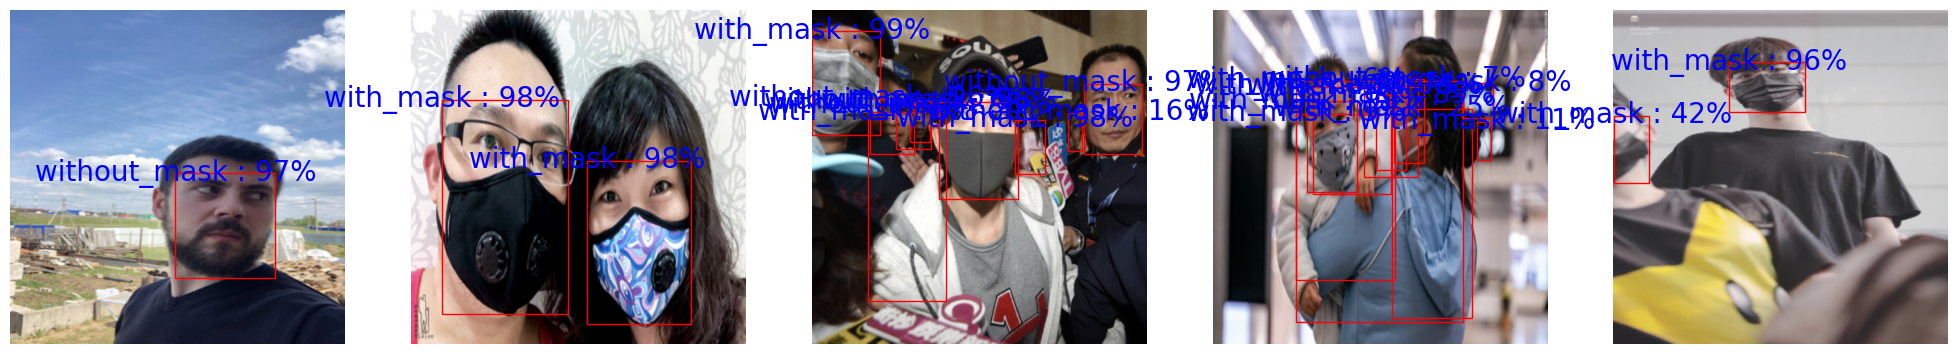

In [40]:
plot_many_images(imgs[:5], preds[:5])

### YOLO Reality
strange thing, when run command torch.hub.load, plt.show() stop working, I did't find solution, so YOLO images will visualized like they work, not like I want :(

In [41]:
import yolov5

# Load the trained model
yolo = torch.hub.load('ultralytics/yolov5', 'custom', path='/kaggle/input/weights/best_yolo.pt') 
#torch.hub.load('ultralytics/yolov5','/kaggle/input/weights/yolov5mbst.pt')  # Load weights
yolo.eval()  # Set the model to evaluation mode
print('ok')

Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip
YOLOv5 🚀 2024-1-18 Python-3.10.12 torch-2.0.0+cpu CPU

Fusing layers... 
Model summary: 212 layers, 20861016 parameters, 0 gradients, 47.9 GFLOPs
Adding AutoShape... 


ok


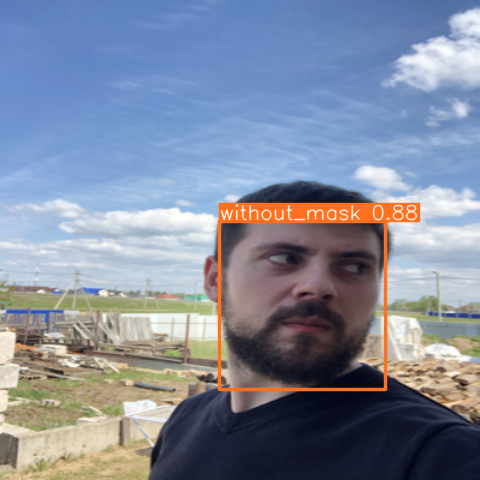

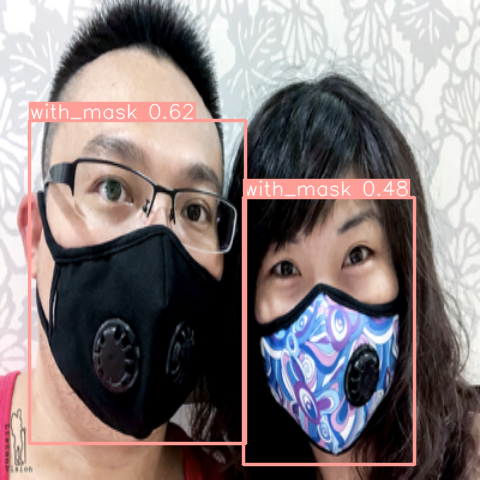

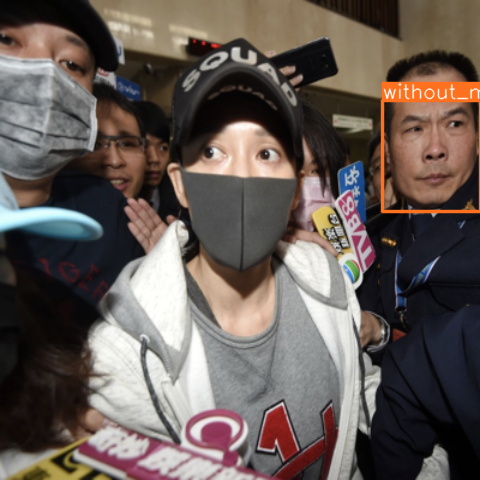

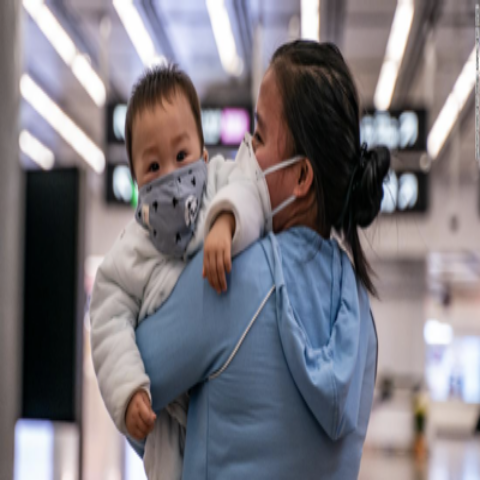

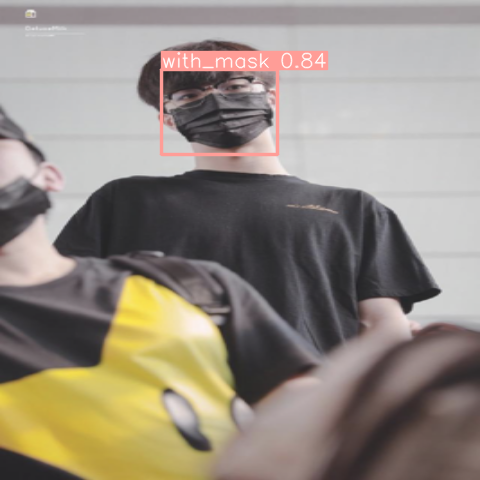

In [42]:
for img in imgs[:5]:
    result= yolo(torch_to_pil(img))
    result.show()

Comparing:
* Speed
  * I lost speed data of F_RCNN model :( 
  * Yolo spend almost 3 hours to training
   * including that I was using hyp-search for bougth models (and forgot to masure that time also :), by my feeling train time is similar F_RCNN train goes slower, but less epochs YOLO many epochs but fast
* Hyperparameter search
  * For YOLO it took forever, I run it on 10 epochs for 500 trails, and I didn't finish it, work day was over I had to go. 350 trails took around 6 hours
  * F_RCNN I made 100 trails and no effect result which I got was much worse than training with basic parameters
* Result
  * YOLO - on train data showed 0.8 on test pictures results are worse than F_RCNN, on last picture even didn't find nothing
  * F_RCNN - train result is 0.75 but on test result it showed quite good results much better than YOLO
  * Bougth models didn't reach 0.85 as asked, but It feels if I would train them for longer time with same parameters I reached needed mAP
  
Conclusion:
If I had to choose from those two models for my project I would choose YOLO. 
Because:
* It is lighter, it take much less resources than F_RCNN
* Better enviroment. It easy to install, train, evaluate much more human friendly
* Results will be worse than if I would use F_RCNN but, including how much time I wasted to prepare F_RCNN and force it to work, if I will spend same time to train YOLO better, I think result will be almost the same
  